# Medical Cost Prediction

### Problem Statement

We will be predicting the medical charges for different paitents based on features like gender , age , bmi etc.
Below are the features captured in our dataset. The dataset is taken from kaggle.


### Features

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
  objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance


In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
%matplotlib inline

import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tools.eval_measures import rmse

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE,RFECV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# EDA

In [4]:
df.shape

(1338, 7)

* There are 1338 observations and 7 attributes

In [5]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

* All the datatypes are inline with data description

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
missing_df = pd.DataFrame({'count':df.isna().sum(),'percent':df.isna().sum()/len(df)})
missing_df

,count,percent
age,0,0.0
sex,0,0.0
bmi,0,0.0
children,0,0.0
smoker,0,0.0
region,0,0.0
charges,0,0.0


* There are no missing values.

In [8]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


* Age and BMI seems to be symmetrical based on thier mean and median values.
* Charges distribution can be a left skewed.
* There are no junk values present in data.

In [9]:
df.skew()

age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64

* Except charges all the features are near to normal distribution.

### Outliers

In [10]:
df_num=df[['age','bmi','children']]

Q1 = df_num.quantile(0.25)

Q3 = df_num.quantile(0.75)

IQR = Q3 - Q1

df_outliers = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


print('Shape of the data before handling outliers : ',df.shape)
print('Shape of the data after handling outliers : ',df_outliers.shape)

Shape of the data before handling outliers :  (1338, 7)
Shape of the data after handling outliers :  (1329, 7)


Inference:
    
    -- As we dont see any significant removal of observations after treating the outliers.
    -- We will proceed with the normal data.

## Univariate Analysis

In [11]:
class style:
#These are the ANSI escape sequences to set Graphics in our output
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   BLINK = '\033[5m'
   END = '\033[0m'

In [12]:
numerical =['age','bmi','charges','children']
categorical=['smoker','region','sex']

In [13]:
def univariate_analysis_categorical(cat, i):
    print(f"\t\t{style.BOLD}Univariate Analysis of {cat}")
    print(f"-----------------------------------------------------------{style.END}")
    print(f"{i+1}. No of unique values in {style.BOLD}{cat}{style.END} are: {df[cat].nunique()}. \nThe distribution is as follows:")
    print(f"{style.BOLD}{cat}{style.END}\n{df[cat].value_counts()}\n")
    vc = df[cat].value_counts()
    if len(vc.index)<=5:
        g = sns.countplot(x=cat, data=df, palette = 'pastel', order = df[cat].value_counts().index)
    elif len(vc.index)>5 and len(vc.index)<=15:
        g = sns.countplot(y=cat, data=df, palette = 'pastel', order = df[cat].value_counts().index)
    elif len(vc.index)>15:
        g = sns.countplot(x=cat, data=df, palette = 'pastel',order = df[cat].value_counts().index)
        g.set_xticklabels(labels = g.get_xticklabels(), rotation = 90)
    plt.show()
    print("\t")

In [14]:
def univariate_analysis_numerical(num, i):
    print(f"\t\t{style.BOLD}Univariate Analysis of {num}")
    print(f"-----------------------------------------------------------{style.END}")
    print(f"{style.BOLD}{num}{style.END}\n")
    print(f"{style.BOLD}The distribution of {num} is as follows:")
    print(sns.boxplot(x=df[num]))
    plt.show()
    print(f"{style.BOLD}The distribution of {num} is as follows:")
    print(sns.distplot(x=df[num]))
    plt.show()
    print("\t")

		Univariate Analysis of smoker
-----------------------------------------------------------
1. No of unique values in smoker are: 2. 
The distribution is as follows:
smoker
no     1064
yes     274
Name: smoker, dtype: int64



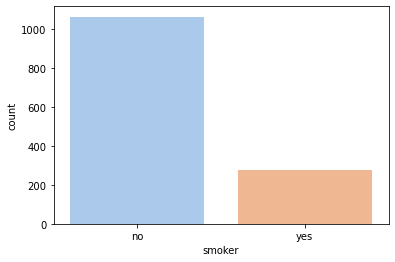

	
		Univariate Analysis of region
-----------------------------------------------------------
2. No of unique values in region are: 4. 
The distribution is as follows:
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64



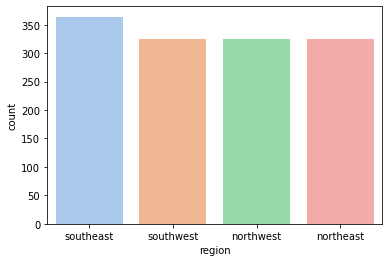

	
		Univariate Analysis of sex
-----------------------------------------------------------
3. No of unique values in sex are: 2. 
The distribution is as follows:
sex
male      676
female    662
Name: sex, dtype: int64



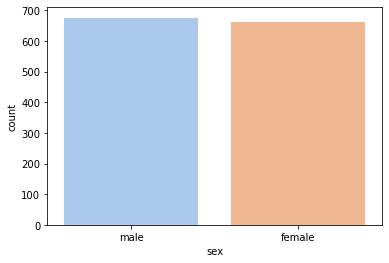

In [15]:
for i,x in enumerate(categorical):
        univariate_analysis_categorical(x, i) 

		Univariate Analysis of age
-----------------------------------------------------------
age

The distribution of age is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


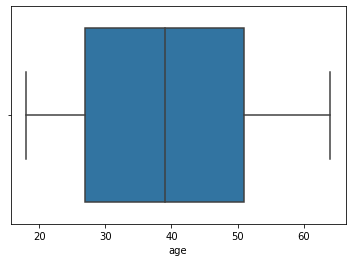

The distribution of age is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


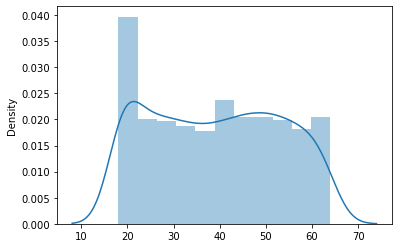

	
		Univariate Analysis of bmi
-----------------------------------------------------------
bmi

The distribution of bmi is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


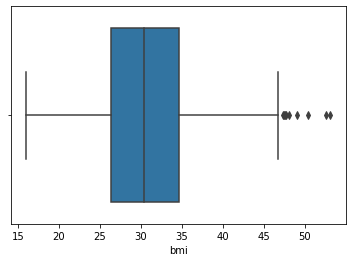

The distribution of bmi is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


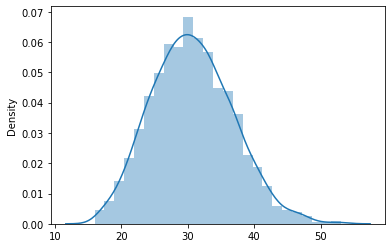

	
		Univariate Analysis of charges
-----------------------------------------------------------
charges

The distribution of charges is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


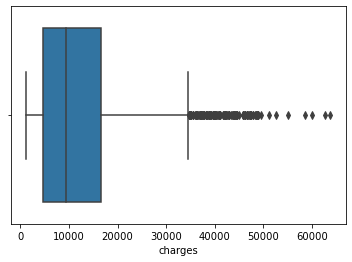

The distribution of charges is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


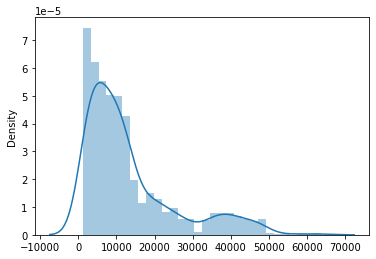

	
		Univariate Analysis of children
-----------------------------------------------------------
children

The distribution of children is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


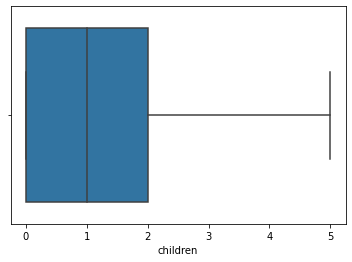

The distribution of children is as follows:
AxesSubplot(0.125,0.125;0.775x0.755)


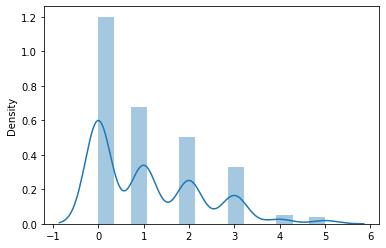

In [16]:
for i,x in enumerate(numerical):
        univariate_analysis_numerical(x, i) 

## Bivariate Analysis

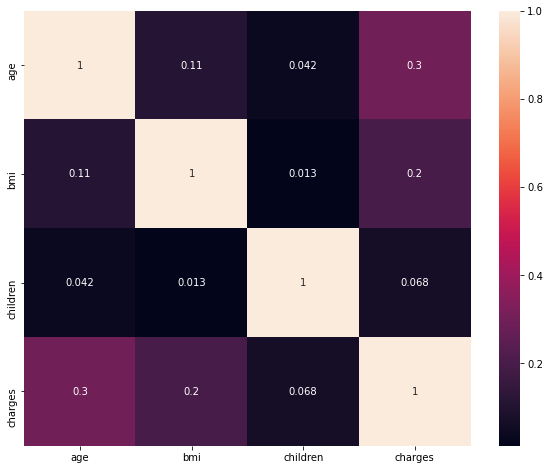

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

* There is no Multicollinearity observed

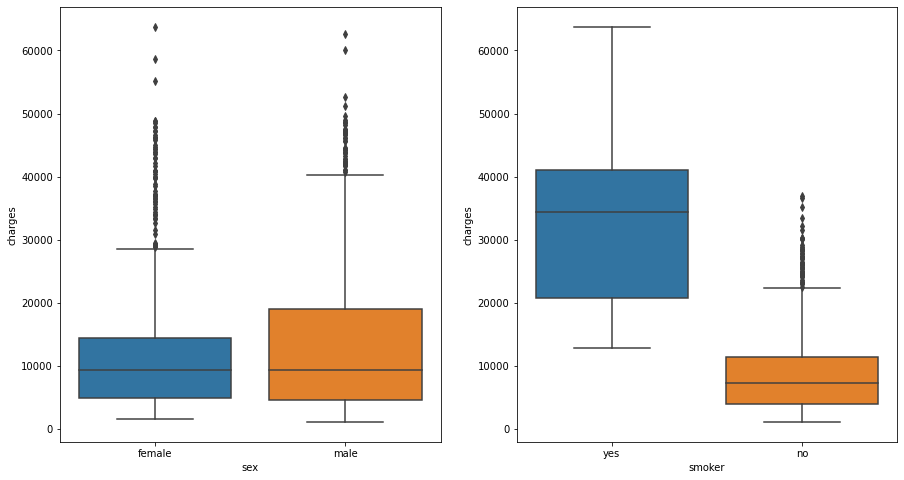

In [18]:
fig , ax = plt.subplots(1,2,figsize=(15,8))
sns.boxplot(df['sex'],df['charges'],ax=ax[0])
sns.boxplot(df['smoker'],df['charges'],ax=ax[1])
plt.show()

* The median charges for both male and female are almost same , there is more spread of data noticed on Male category.
* Medical Charges for smokers are very high compared to non smokers.

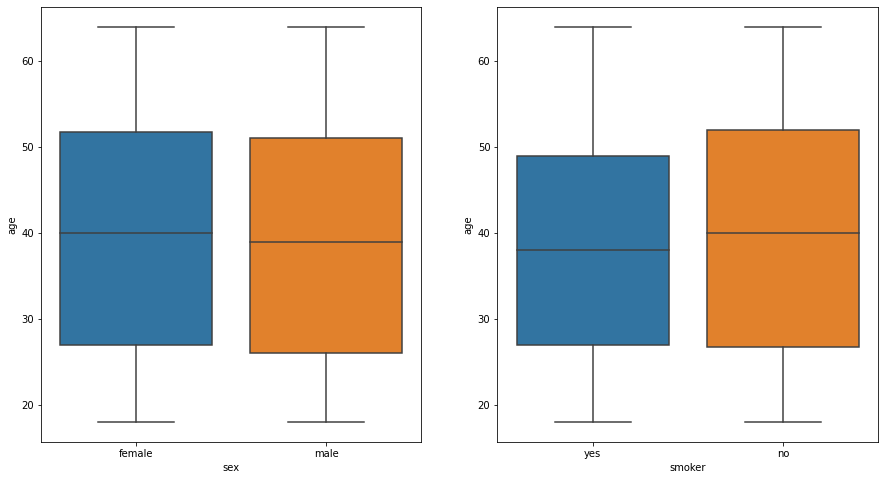

In [19]:
fig , ax = plt.subplots(1,2,figsize=(15,8))
sns.boxplot(df['sex'],df['age'],ax=ax[0])
sns.boxplot(df['smoker'],df['age'],ax=ax[1])
plt.show()

* There is no signifiant different spread of data for males and females,smokers and non smokers with respect to Age

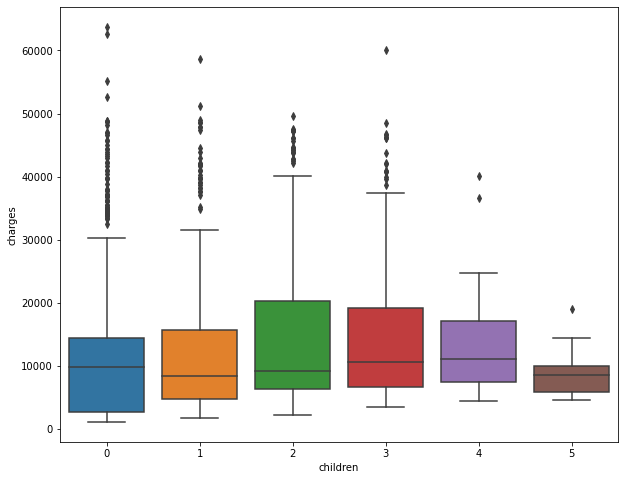

In [20]:
plt.figure(figsize=(10,8))
sns.boxplot(df['children'],df['charges'])
plt.show()

* The median medical charges are high for the individuals who doesn't have childern.
* There are ceratin outliers noticed in all the groups.

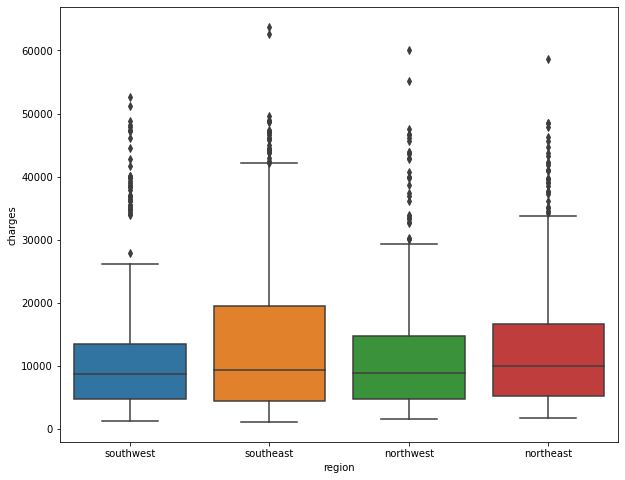

In [21]:
plt.figure(figsize=(10,8))
sns.boxplot(df['region'],df['charges'])
plt.show()

* The median charges for all teh regions are almost same, but the spread is more in southeast region.
* Outliers were noticed in all the regions.

## Multivariate Analysis

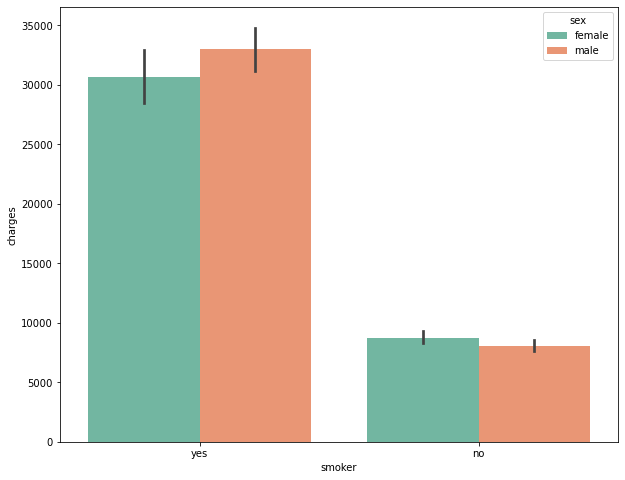

In [22]:
plt.figure(figsize=(10,8))
sns.barplot(df['smoker'],df['charges'],hue='sex',data=df,palette='Set2')
plt.show()

* The mean charges for Male smokers are high than Female charges.
* There is no much difference of charges noticed in terms of non smokers.

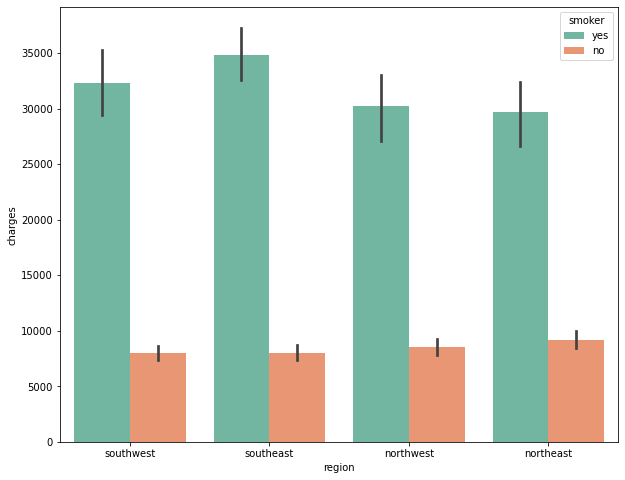

In [23]:
plt.figure(figsize=(10,8))
sns.barplot(df['region'],df['charges'],hue='smoker',data=df,palette='Set2')
plt.show()

* The mean charges for smokers in all the regions are high comapred to non smokers.
* The more number of smokers are noticed in Southeast region.

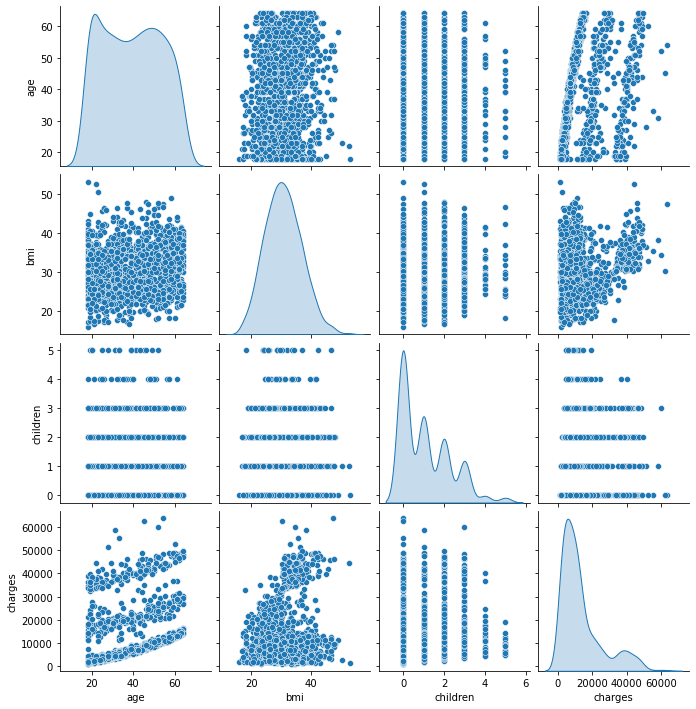

In [24]:
plt.rcParams['figure.figsize'] = (22,7)
sns.pairplot(df,diag_kind='kde')
plt.show()

* There is no linear trend observed between the features.

## Encoding

In [25]:
df_encode = pd.get_dummies(df,drop_first=True)
df_encode.sample(5)

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
61,25,33.660,4,4504.66240,1,0,0,1,0
1192,58,32.395,1,13019.16105,0,0,0,0,0
258,51,24.415,4,11520.09985,1,0,1,0,0
728,18,40.280,0,2217.60120,0,0,0,0,0
645,48,30.780,3,10141.13620,1,0,0,0,0


#### Data preparation

In [26]:
X = df_encode.drop('charges',1)
y = df_encode.charges

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0)

print('X Train shape: ',x_train.shape)
print('X Test shape: ',x_test.shape)
print('Y Train shape: ',y_train.shape)
print('Y Test shape: ',y_test.shape)

X Train shape:  (1070, 8)
X Test shape:  (268, 8)
Y Train shape:  (1070,)
Y Test shape:  (268,)


## Model Building

In [27]:
lr = LinearRegression()
model = lr.fit(x_train,y_train)
ypred_train = model.predict(x_train)
ypred_test = model.predict(x_test)
mse_train = mean_squared_error(y_train,ypred_train)
mse_test = mean_squared_error(y_test,ypred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"{style.BOLD}R Square")
print('--------------------------')
print(round(r2_score(y_test,ypred_test),3))
print('\n')
print(f"{style.BOLD}RMSE of Train Data")
print('--------------------------')
print(round(rmse_train,2))
print('\n')
print(f"{style.BOLD}RMSE of Test Data")
print('--------------------------')
print(round(rmse_test,2))

R Square
--------------------------
0.8


RMSE of Train Data
--------------------------
6140.16


RMSE of Test Data
--------------------------
5641.63


In [28]:
X_l = df_encode.drop('charges',1)
X_l = sm.add_constant(X_l)
y_l = df_encode.charges

x_train_l,x_test_l,y_train_l,y_test_l = train_test_split(X_l,y_l,test_size=0.20,random_state=10)

In [29]:
model_l=sm.OLS(y_train_l,x_train_l).fit()
model_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     428.5
Date:                Sat, 09 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:29:21   Log-Likelihood:                -10812.
No. Observations:                1070   AIC:                         2.164e+04
Df Residuals:                    1061   BIC:                         2.169e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.272e+04   1068.346    -11.904      0.000   -1.48e+04   -1.06e+04
age                259.5474     13.013     19.946      0.000     234.014     285.081
bmi                353.0377     31.141     11.337      0.000     291.932     414.143
children           543.2893    150.674      3.606      0.000     247.636     838.942
sex_male          -254.3976    366.133     -0.695      0.487    -972.825     464.030
smoker_yes        2.412e+04    455.121     53.006      0.000    2.32e+04     2.5e+04
region_northwest  -192.0025    519.443     -0.370      0.712   -1211.254     827.249
region_southeast  -896.1336    520.833     -1.721      0.086   -1918.113     125.846
region_southwest  -618.2897    519.929     -1.189      0.235   -1638.497     401.917
==============================================================================
Omnibus:                      228.399   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              538.981
Skew:                           1.149   Prob(JB):                    9.15e-118
Kurtosis:                       5.609   Cond. No.                         308.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* From above summary we can see that R square and Adj R square are similar.
* Model is able to explain 76% of variance.
* There is no Auto correlation confirmed by Durbin Watson test
* There is Moderate Multicollinearity as per Condition Number.
* As per JB test the model residuals are not normally distributed

In [30]:
def adj_r(ytest,ypred):
    result = 1 - (1-r2_score(ytest,ypred))*(len(y)-1)/(len(y)-X.shape[1]-1)
    return result

In [31]:
score_card = pd.DataFrame(columns=['Model_Name', 'R-Squared', 'Adj. R-Squared', 'RMSE Train','RMSE Test'])

# print the score card
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test


In [32]:
base_model_sklearn = pd.Series({'Model_Name' : 'Base Model Sklearn',
           'R-Squared' : r2_score(y_test,ypred_test),
           'Adj. R-Squared' : adj_r(y_test,ypred_test),
           'RMSE Train' : rmse_train,
           'RMSE Test' : rmse_test})

score_card=score_card.append(base_model_sklearn,ignore_index=True)

score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559


### Distribution of Target

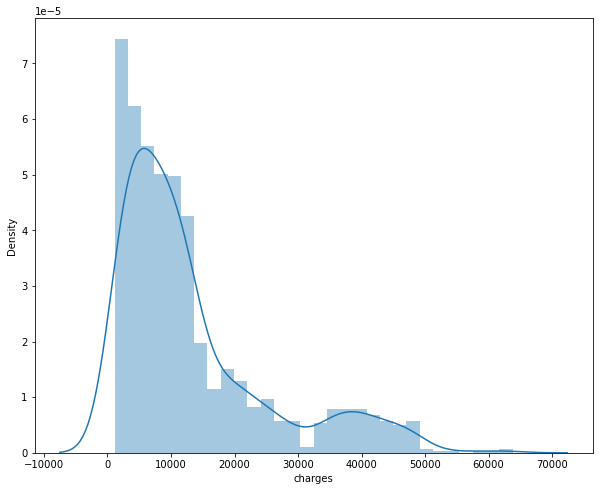

In [33]:
plt.figure(figsize=(10,8))
sns.distplot(df['charges'])
plt.show()

Inference:

    -- As it is right skewed data.
    -- We will apply log transform and test if that will improve the performance.

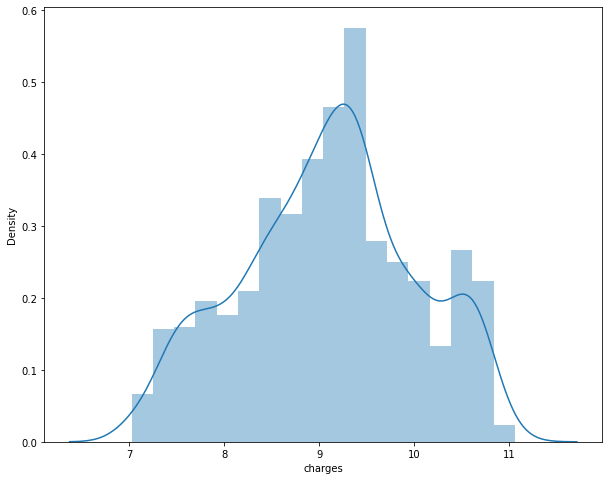

In [34]:
target_log = np.log(df['charges'])
plt.figure(figsize=(10,8))
sns.distplot(target_log)
plt.show()

In [35]:
X_log = df_encode.drop('charges',1)
y_log = target_log

x_train_log,x_test_log,y_train_log,y_test_log = train_test_split(X_log,y_log,test_size=0.20,random_state=0)

print('X Train shape: ',x_train_log.shape)
print('X Test shape: ',x_test_log.shape)
print('Y Train shape: ',y_train_log.shape)
print('Y Test shape: ',y_test_log.shape)

X Train shape:  (1070, 8)
X Test shape:  (268, 8)
Y Train shape:  (1070,)
Y Test shape:  (268,)


In [36]:
lr = LinearRegression()
model_log = lr.fit(x_train_log,y_train_log)
ypred_train_log = model_log.predict(x_train_log)
ypred_test_log = model_log.predict(x_test_log)

predicted_val_train = np.exp(ypred_train_log)
predicted_val_test = np.exp(ypred_test_log)

mse_train_log = mean_squared_error(y_train,predicted_val_train)
mse_test_log = mean_squared_error(y_test,predicted_val_test)

rmse_train_log = np.sqrt(mse_train_log)
rmse_test_log = np.sqrt(mse_test_log)

print(f"{style.BOLD}R Square")
print('--------------------------')
print((r2_score(y_test,predicted_val_test)))
print('\n')
print(f"{style.BOLD}RMSE of Train Data")
print('--------------------------')
print(rmse_train_log)
print('\n')
print(f"{style.BOLD}RMSE of Test Data")
print('--------------------------')
print(rmse_test_log)

R Square
--------------------------
0.5466423980693151


RMSE of Train Data
--------------------------
8370.445972552421


RMSE of Test Data
--------------------------
8493.69048845548


In [37]:
target_log_sklearn = pd.Series({'Model_Name' : 'Target Log Model',
           'R-Squared' : r2_score(y_test,predicted_val_test),
           'Adj. R-Squared' : adj_r(y_test,predicted_val_test),
           'RMSE Train' : rmse_train_log,
           'RMSE Test' : rmse_test_log})

score_card=score_card.append(target_log_sklearn,ignore_index=True)
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559
1,Target Log Model,0.546642,0.543913,8370.445973,8493.690488


Inference:
    
    -- As the Base model is providing us a good results compare to log tarsformed target column.
    -- We will proceed with Base model.

### Feature Selection:

Forward selection

In [55]:
# Build Lin Reg  to use in feature selection
linR = LinearRegression()

# Build step forward feature selection/backward elimination
sfs1 = sfs(linR, k_features=6, forward=True,scoring='r2', cv=5)

# Perform SFFS
sfs1 = sfs1.fit(x_train.values, y_train.values)


In [56]:
sfs1.k_feature_names_

('0', '1', '2', '4', '6', '7')

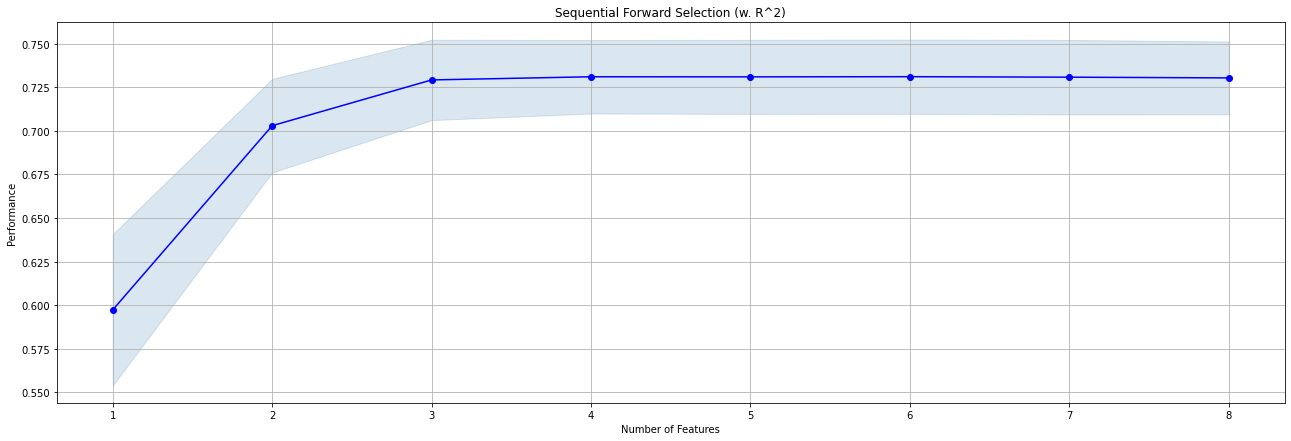

In [39]:
fig = plot_sfs(sfs1.get_metric_dict())

plt.title('Sequential Forward Selection (w. R^2)')
plt.grid()
plt.show()

Backward Feature Elimination

In [58]:
# Build Lin Reg  to use in feature selection
linR = LinearRegression()

# Build step forward feature selection/backward elimination
sfs2 = sfs(linR, k_features=6, forward=False,scoring='r2', cv=5)

# Perform SFFS
sfs2 = sfs2.fit(x_train.values, y_train.values)

In [59]:
sfs2.k_feature_names_

('0', '1', '2', '4', '6', '7')

Recurssive Feature Elimination

In [42]:
lr = LinearRegression()
lr.fit(x_train.values, y_train.values)

rfe_model = RFECV(estimator=lr, min_features_to_select=1)


rfe_model = rfe_model.fit(x_train.values, y_train.values)
 
feat_index = pd.Series(data = rfe_model.ranking_, index = X.columns)

signi_feat_rfe = feat_index[feat_index==1].index

# print the significant features obtained from RFE
print(signi_feat_rfe)

Index(['age', 'bmi', 'children', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')


Based On p-values:

In [60]:
model_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     428.5
Date:                Sat, 09 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:41:05   Log-Likelihood:                -10812.
No. Observations:                1070   AIC:                         2.164e+04
Df Residuals:                    1061   BIC:                         2.169e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.272e+04   1068.346    -11.904      0.000   -1.48e+04   -1.06e+04
age                259.5474     13.013     19.946      0.000     234.014     285.081
bmi                353.0377     31.141     11.337      0.000     291.932     414.143
children           543.2893    150.674      3.606      0.000     247.636     838.942
sex_male          -254.3976    366.133     -0.695      0.487    -972.825     464.030
smoker_yes        2.412e+04    455.121     53.006      0.000    2.32e+04     2.5e+04
region_northwest  -192.0025    519.443     -0.370      0.712   -1211.254     827.249
region_southeast  -896.1336    520.833     -1.721      0.086   -1918.113     125.846
region_southwest  -618.2897    519.929     -1.189      0.235   -1638.497     401.917
==============================================================================
Omnibus:                      228.399   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              538.981
Skew:                           1.149   Prob(JB):                    9.15e-118
Kurtosis:                       5.609   Cond. No.                         308.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
model_l.pvalues[model_l.pvalues<0.05].index

Index(['const', 'age', 'bmi', 'children', 'smoker_yes'], dtype='object')

Inference:
    
    -- Based on the Bivariate Analysis
    -- All the feature selection methods peformed above , the important features obtained are 'age', 'bmi', 'children',            'smoker_yes'

In [62]:
X_sig= df_encode.drop(['charges','sex_male','region_northwest','region_southeast','region_southwest'],1)
y_sig = df.charges

x_train_sig,x_test_sig,y_train_sig,y_test_sig = train_test_split(X_sig,y_sig,test_size=0.20,random_state=0)

print('X Train shape: ',x_train_sig.shape)
print('X Test shape: ',x_test_sig.shape)
print('Y Train shape: ',y_train_sig.shape)
print('Y Test shape: ',y_test_sig.shape)

X Train shape:  (1070, 4)
X Test shape:  (268, 4)
Y Train shape:  (1070,)
Y Test shape:  (268,)


In [63]:
lr = LinearRegression()
model_sig = lr.fit(x_train_sig,y_train_sig)

ypred_train_sig = model_sig.predict(x_train_sig)
ypred_test_sig = model_sig.predict(x_test_sig)

mse_train_sig = mean_squared_error(y_train_sig,ypred_train_sig)
mse_test_sig = mean_squared_error(y_test_sig,ypred_test_sig)

rmse_train_sig = np.sqrt(mse_train_sig)
rmse_test_sig = np.sqrt(mse_test_sig)

print(f"{style.BOLD}R Square")
print('--------------------------')
print(round(r2_score(y_test_sig,ypred_test_sig),3))
print('\n')
print(f"{style.BOLD}RMSE of Train Data")
print('--------------------------')
print(round(rmse_train_sig,2))
print('\n')
print(f"{style.BOLD}RMSE of Test Data")
print('--------------------------')
print(round(rmse_test_sig,2))

R Square
--------------------------
0.798


RMSE of Train Data
--------------------------
6150.52


RMSE of Test Data
--------------------------
5672.01


In [64]:
sig_model = pd.Series({'Model_Name' : 'Model with Significant Feature',
           'R-Squared' : r2_score(y_test_sig,ypred_test_sig),
           'Adj. R-Squared' : adj_r(y_test_sig,ypred_test_sig),
           'RMSE Train' : rmse_train_sig,
           'RMSE Test' : rmse_test_sig})

score_card=score_card.append(sig_model,ignore_index=True)
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559
1,Target Log Model,0.546642,0.543913,8370.445973,8493.690488
2,Model with Significant Feature,0.797827,0.796610,6150.519470,5672.010981


### Polynomial Regression

In [74]:
#Grouping non linear features to raise degree.
x_nonlinear=df_encode[['age', 'bmi', 'children','smoker_yes']]
y_p=df.charges

#Genearting polynomial features and loading it as a dataframe
quad = PolynomialFeatures(degree = 2)
x_quad = quad.fit_transform(x_nonlinear)

X_train_p,X_test_p,y_train_p,y_test_p = train_test_split(x_quad,y_p,test_size=0.20 ,random_state = 0)

print('X Train shape: ',X_train_p.shape)
print('X Test shape: ',X_test_p.shape)
print('Y Train shape: ',y_train_p.shape)
print('Y Test shape: ',y_test_p.shape)

X Train shape:  (1070, 15)
X Test shape:  (268, 15)
Y Train shape:  (1070,)
Y Test shape:  (268,)


In [75]:
lr = LinearRegression()
model_p = lr.fit(X_train_p,y_train_p)

ypred_train_p = model_p.predict(X_train_p)
ypred_test_p = model_p.predict(X_test_p)

mse_train_p = mean_squared_error(y_train_p,ypred_train_p)
mse_test_p = mean_squared_error(y_test_sig,ypred_test_p)

rmse_train_p = np.sqrt(mse_train_p)
rmse_test_p = np.sqrt(mse_test_p)

print(f"{style.BOLD}R Square")
print('--------------------------')
print(round(r2_score(y_test_sig,ypred_test_p),3))
print('\n')
print(f"{style.BOLD}RMSE of Train Data")
print('--------------------------')
print(round(rmse_train_p,2))
print('\n')
print(f"{style.BOLD}RMSE of Test Data")
print('--------------------------')
print(round(rmse_test_p,2))

R Square
--------------------------
0.881


RMSE of Train Data
--------------------------
4902.87


RMSE of Test Data
--------------------------
4346.86


In [69]:
ploy_model = pd.Series({'Model_Name' : 'Model with Polynomial Features',
           'R-Squared' : r2_score(y_test_sig,ypred_test_p),
           'Adj. R-Squared' : adj_r(y_test_sig,ypred_test_p),
           'RMSE Train' : rmse_train_p,
           'RMSE Test' : rmse_test_p})

score_card=score_card.append(ploy_model,ignore_index=True)
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559
1,Target Log Model,0.546642,0.543913,8370.445973,8493.690488
2,Model with Significant Feature,0.797827,0.796610,6150.519470,5672.010981
3,Model with Polynomial Features,0.881260,0.880545,4902.872472,4346.856347


## Conclusion on Linear Model

   **From the above score card we can conclude that the Model with Polynomial degree as 2 is able to explain 
    88% of variation** 
    
   **Model build with Ploynomial Features is the final linear model with best results for the provided data.**
   
   **And also by seeing the RMSE values we can infer that our model is not overfitting , its a good fit model.**

## Non-Linear Models

### Decision Tree

In [77]:
X = df_encode.drop('charges',1)
y = df_encode.charges

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0)

print('X Train shape: ',x_train.shape)
print('X Test shape: ',x_test.shape)
print('Y Train shape: ',y_train.shape)
print('Y Test shape: ',y_test.shape)

X Train shape:  (1070, 8)
X Test shape:  (268, 8)
Y Train shape:  (1070,)
Y Test shape:  (268,)


In [83]:
dt = DecisionTreeRegressor()
model_dt = dt.fit(x_train,y_train)

ypred_train_dt = model_dt.predict(x_train)
ypred_test_dt = model_dt.predict(x_test)

mse_train_dt = mean_squared_error(y_train,ypred_train_dt)
mse_test_dt = mean_squared_error(y_test,ypred_test_dt)

rmse_train_dt = np.sqrt(mse_train_dt)
rmse_test_dt = np.sqrt(mse_test_dt)

print(f"{style.BOLD}R Square")
print('--------------------------')
print(round(r2_score(y_test,ypred_test_dt),3))
print('\n')
print(f"{style.BOLD}RMSE of Train Data")
print('--------------------------')
print(round(rmse_train_dt,2))
print('\n')
print(f"{style.BOLD}RMSE of Test Data")
print('--------------------------')
print(round(rmse_test_dt,2))

R Square
--------------------------
0.686


RMSE of Train Data
--------------------------
494.21


RMSE of Test Data
--------------------------
7067.78


In [86]:
tree_model = pd.Series({'Model_Name' : 'Decision Tree Regressor',
           'R-Squared' : r2_score(y_test,ypred_test_dt),
           'Adj. R-Squared' : adj_r(y_test,ypred_test_dt),
           'RMSE Train' : rmse_train_dt,
           'RMSE Test' : rmse_test_dt})

score_card=score_card.append(tree_model,ignore_index=True)
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559
1,Target Log Model,0.546642,0.543913,8370.445973,8493.690488
2,Model with Significant Feature,0.797827,0.796610,6150.519470,5672.010981
3,Model with Polynomial Features,0.881260,0.880545,4902.872472,4346.856347
4,Decision Tree Regressor,0.686084,0.684194,494.205984,7067.778120


### Feature Importance

In [81]:
important = pd.DataFrame({'Features':x_train.columns,'Importance':model_dt.feature_importances_})
important.sort_values(by='Importance',ascending = False)

,Features,Importance
4,smoker_yes,0.605352
1,bmi,0.219559
0,age,0.131592
2,children,0.017447
5,region_northwest,0.008777
7,region_southwest,0.007213
6,region_southeast,0.005636
3,sex_male,0.004424


In [84]:
X_sig= df_encode.drop(['charges','sex_male','region_northwest','region_southeast','region_southwest'],1)
y_sig = df.charges

x_train_sig,x_test_sig,y_train_sig,y_test_sig = train_test_split(X_sig,y_sig,test_size=0.20,random_state=0)

print('X Train shape: ',x_train_sig.shape)
print('X Test shape: ',x_test_sig.shape)
print('Y Train shape: ',y_train_sig.shape)
print('Y Test shape: ',y_test_sig.shape)

X Train shape:  (1070, 4)
X Test shape:  (268, 4)
Y Train shape:  (1070,)
Y Test shape:  (268,)


In [85]:
dt = DecisionTreeRegressor()
model_dt_sig = dt.fit(x_train_sig,y_train_sig)

ypred_train_dt_sig = model_dt_sig.predict(x_train_sig)
ypred_test_dt_sig = model_dt_sig.predict(x_test_sig)

mse_train_dt_sig = mean_squared_error(y_train_sig,ypred_train_dt_sig)
mse_test_dt_sig = mean_squared_error(y_test_sig,ypred_test_dt_sig)

rmse_train_dt_sig = np.sqrt(mse_train_dt_sig)
rmse_test_dt_sig = np.sqrt(mse_test_dt_sig)

print(f"{style.BOLD}R Square")
print('--------------------------')
print(round(r2_score(y_test_sig,ypred_test_dt_sig),3))
print('\n')
print(f"{style.BOLD}RMSE of Train Data")
print('--------------------------')
print(round(rmse_train_dt_sig,2))
print('\n')
print(f"{style.BOLD}RMSE of Test Data")
print('--------------------------')
print(round(rmse_test_dt_sig,2))

R Square
--------------------------
0.727


RMSE of Train Data
--------------------------
494.66


RMSE of Test Data
--------------------------
6589.9


In [87]:
tree_model_sig = pd.Series({'Model_Name' : 'Decision Tree Regressor with Significant Features',
           'R-Squared' : r2_score(y_test_sig,ypred_test_dt_sig),
           'Adj. R-Squared' : adj_r(y_test_sig,ypred_test_dt_sig),
           'RMSE Train' : rmse_train_dt_sig,
           'RMSE Test' : rmse_test_dt_sig})

score_card=score_card.append(tree_model_sig,ignore_index=True)
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559
1,Target Log Model,0.546642,0.543913,8370.445973,8493.690488
2,Model with Significant Feature,0.797827,0.796610,6150.519470,5672.010981
3,Model with Polynomial Features,0.881260,0.880545,4902.872472,4346.856347
4,Decision Tree Regressor,0.686084,0.684194,494.205984,7067.778120
5,Decision Tree Regressor with Significant Features,0.727099,0.725456,494.660483,6589.901429


### HyperParameter Tuning:

In [89]:
tune = [{'criterion':['mse','mae','squared_error'],
         'max_depth':[2,3,4,5,6]
        }]

dt = DecisionTreeRegressor()
gv = GridSearchCV(estimator=dt,param_grid=tune,scoring='r2',cv=5)
model_gv = gv.fit(x_train,y_train)
model_gv.best_params_

{'criterion': 'mae', 'max_depth': 4}

In [90]:
dt = DecisionTreeRegressor(criterion='mae',max_depth=4)
model_dt_tune = dt.fit(x_train_sig,y_train_sig)

ypred_train_dt_tune = model_dt_tune.predict(x_train_sig)
ypred_test_dt_tune = model_dt_tune.predict(x_test_sig)

mse_train_dt_tune = mean_squared_error(y_train_sig,ypred_train_dt_tune)
mse_test_dt_tune = mean_squared_error(y_test_sig,ypred_test_dt_tune)

rmse_train_dt_tune = np.sqrt(mse_train_dt_tune)
rmse_test_dt_tune = np.sqrt(mse_test_dt_tune)

print(f"{style.BOLD}R Square")
print('--------------------------')
print(round(r2_score(y_test_sig,ypred_test_dt_tune),3))
print('\n')
print(f"{style.BOLD}RMSE of Train Data")
print('--------------------------')
print(round(rmse_train_dt_tune,2))
print('\n')
print(f"{style.BOLD}RMSE of Test Data")
print('--------------------------')
print(round(rmse_test_dt_tune,2))

R Square
--------------------------
0.887


RMSE of Train Data
--------------------------
4722.17


RMSE of Test Data
--------------------------
4247.53


In [91]:
tree_model_sig_tune = pd.Series({'Model_Name' : 'Tuned Decision Tree Regressor with Significant Features',
           'R-Squared' : r2_score(y_test_sig,ypred_test_dt_tune),
           'Adj. R-Squared' : adj_r(y_test_sig,ypred_test_dt_tune),
           'RMSE Train' : rmse_train_dt_tune,
           'RMSE Test' : rmse_test_dt_tune})

score_card=score_card.append(tree_model_sig_tune,ignore_index=True)
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559
1,Target Log Model,0.546642,0.543913,8370.445973,8493.690488
2,Model with Significant Feature,0.797827,0.796610,6150.519470,5672.010981
3,Model with Polynomial Features,0.881260,0.880545,4902.872472,4346.856347
4,Decision Tree Regressor,0.686084,0.684194,494.205984,7067.778120
5,Decision Tree Regressor with Significant Features,0.727099,0.725456,494.660483,6589.901429
6,Tuned Decision Tree Regressor with Significant...,0.886624,0.885942,4722.166439,4247.529214


### Ensemble Models

In [106]:
gb = GradientBoostingRegressor()
model_gb = dt.fit(x_train_sig,y_train_sig)

ypred_train_gb = model_gb.predict(x_train_sig)
ypred_test_gb = model_gb.predict(x_test_sig)

mse_train_gb = mean_squared_error(y_train_sig,ypred_train_gb)
mse_test_gb = mean_squared_error(y_test_sig,ypred_test_gb)

rmse_train_gb = np.sqrt(mse_train_gb)
rmse_test_gb = np.sqrt(mse_test_gb)

print(f"{style.BOLD}R Square")
print('--------------------------')
print(round(r2_score(y_test_sig,ypred_test_gb),3))
print('\n')
print(f"{style.BOLD}RMSE of Train Data")
print('--------------------------')
print(round(rmse_train_gb,2))
print('\n')
print(f"{style.BOLD}RMSE of Test Data")
print('--------------------------')
print(round(rmse_test_gb,2))

R Square
--------------------------
0.887


RMSE of Train Data
--------------------------
4722.17


RMSE of Test Data
--------------------------
4247.53


In [99]:
gb_model = pd.Series({'Model_Name' : 'GrdientBoosting Regressor with Significant Features',
           'R-Squared' : r2_score(y_test_sig,ypred_test_gb),
           'Adj. R-Squared' : adj_r(y_test_sig,ypred_test_gb),
           'RMSE Train' : rmse_train_gb,
           'RMSE Test' : rmse_test_gb})

score_card=score_card.append(gb_model,ignore_index=True)
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559
1,Target Log Model,0.546642,0.543913,8370.445973,8493.690488
2,Model with Significant Feature,0.797827,0.796610,6150.519470,5672.010981
3,Model with Polynomial Features,0.881260,0.880545,4902.872472,4346.856347
4,Decision Tree Regressor,0.686084,0.684194,494.205984,7067.778120
5,Decision Tree Regressor with Significant Features,0.727099,0.725456,494.660483,6589.901429
6,Tuned Decision Tree Regressor with Significant...,0.886624,0.885942,4722.166439,4247.529214
7,GrdientBoosting Regressor with Significant Fea...,0.886624,0.885942,4722.166439,4247.529214


### Bais and Variance Error:

In [108]:
gb=GradientBoostingRegressor()
cross_val = cross_val_score(estimator=gb,X=x_train_sig,y=y_train_sig,scoring='r2',cv=5)
bais = (1 - np.mean(cross_val))
variance = np.std(cross_val)/np.mean(cross_val)

print(f"{style.BOLD}Bais Error")
print('--------------------------')
print(bais)
print('\n')
print(f"{style.BOLD}Variance Error")
print('--------------------------')
print(variance)

Bais Error
--------------------------
0.1604920718369014


Variance Error
--------------------------
0.03136169224564467


### Inference :

**For the given data we have got 16% unexplained error / Bias error.**

**On an average 16% of difference can be expected while predictions in terms of charges**

**For the given data we have 3% variance , i.e when tried on different data sets we can expect on an average 3% of variation in the prediction values.** 


In [109]:
score_card

,Model_Name,R-Squared,Adj. R-Squared,RMSE Train,RMSE Test
0,Base Model Sklearn,0.799988,0.798784,6140.157419,5641.626559
1,Target Log Model,0.546642,0.543913,8370.445973,8493.690488
2,Model with Significant Feature,0.797827,0.796610,6150.519470,5672.010981
3,Model with Polynomial Features,0.881260,0.880545,4902.872472,4346.856347
4,Decision Tree Regressor,0.686084,0.684194,494.205984,7067.778120
5,Decision Tree Regressor with Significant Features,0.727099,0.725456,494.660483,6589.901429
6,Tuned Decision Tree Regressor with Significant...,0.886624,0.885942,4722.166439,4247.529214
7,GrdientBoosting Regressor with Significant Fea...,0.886624,0.885942,4722.166439,4247.529214


# CONCLUSION:

#### Build Different Models:
    
    -- Model With all the features
    -- Log transformed the target column
    -- Model with only significant features
    -- Model with polynomial regression
    -- Non-Linear Models like Decision tree
    -- Decision Tree with significant features
    -- Decision tree with best parameters using GridSearch Cv
    -- Finally tried ensemble model Gradient Boosting.

### In Linear Models , Model with Polynomial Regerssion with significant features gave us best results.

### In Non-Linear Models, Tuned Decision Tree with Significant features gave us the best results with less RMSE

### GradientBoosting also gave us the same results as Tuned Decision Tree with Significant features model



## Considering Tuned Decision Tree with Significant features as the Final Model considering models R2 and RMSE for both Train and Test